# Random Forest Classification


## Data Preprocessing


In [1]:
dataset_path = '../Datasets/SVM-main-data/Social_Network_Ads.csv'


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


### Loading the data


In [3]:
data = pd.read_csv(dataset_path).drop(columns=['User ID'])
data.head(n=5)


,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


In [4]:
data.shape


(400, 4)

### One Hot Encoding


In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

categorical_columns = ['Gender']

# Fit the encoder
encoded_data = encoder.fit_transform(data[categorical_columns])

# Convert the encoded data to a new dataframe
encoded_df = pd.DataFrame(encoded_data.toarray(
), columns=encoder.get_feature_names_out(categorical_columns))

# convert from float to int
encoded_df = encoded_df.astype(int)

# Concatenate the encoded dataframe with the original dataframe
new_data = pd.concat([data, encoded_df], axis=1)

# Drop the original categorical columns (string columns)
new_data.drop(categorical_columns, axis=1, inplace=True)


### Count the values of 'Purchased'


In [6]:
new_data['Purchased'].value_counts()


Purchased
0    257
1    143
Name: count, dtype: int64

In [7]:
new_data.head(n=5)


,Age,EstimatedSalary,Purchased,Gender_Female,Gender_Male
0,19,19000,0,0,1
1,35,20000,0,0,1
2,26,43000,0,1,0
3,27,57000,0,1,0
4,19,76000,0,0,1


### Check for missing values


In [8]:
new_data.isnull().sum()


Age                0
EstimatedSalary    0
Purchased          0
Gender_Female      0
Gender_Male        0
dtype: int64

### Correlation Matrix


In [9]:
# get the correlation matrix
corr_matrix = new_data.corr()[['Purchased']].sort_values(
    by='Purchased', ascending=False)


# display the correlation matrix with a heatmap
corr_matrix.style.background_gradient(cmap='coolwarm')


,Purchased
Purchased,1.000000
Age,0.622454
EstimatedSalary,0.362083
Gender_Female,0.042469
Gender_Male,-0.042469


# Build the model


## Spliting the data


In [10]:
# split the data into train and test
from sklearn.model_selection import train_test_split

target = 'Purchased'
X = new_data.drop(columns=target)
y = new_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [11]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (320, 4)
X_test shape: (80, 4)
y_train shape: (320,)
y_test shape: (80,)


## Create the Random Forest Classifier


In [12]:
# create the radom forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=4, random_state=42)


In [13]:
# fit the model on the training data
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=4, random_state=42)

## Test the model


In [14]:
model.score(X_test, y_test)


0.9

In [15]:
# make predictions on the test data
y_pred = model.predict(X_test)


### Confusion Matrix


In [16]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# display the confusion matrix as a table with labels
pd.DataFrame(cm, index=['Actual 0', 'Actual 1'],
             columns=['Predicted 0', 'Predicted 1'])


,Predicted 0,Predicted 1
Actual 0,48,4
Actual 1,4,24


### Visualize the accuracy

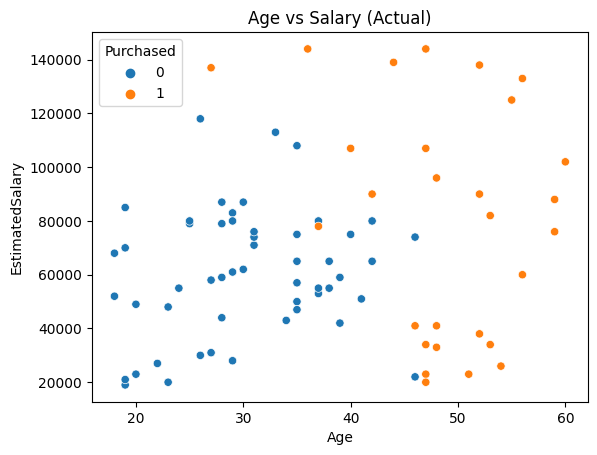

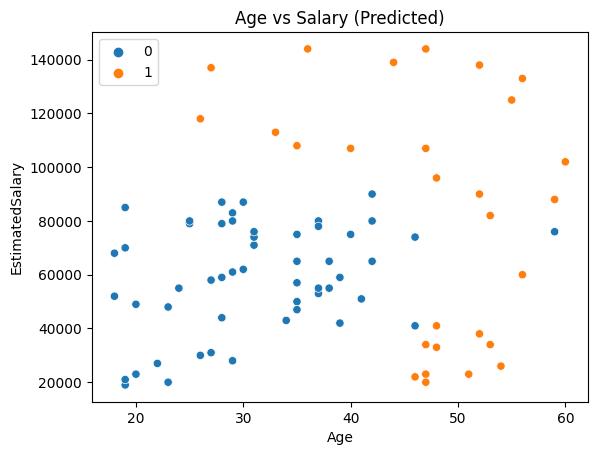

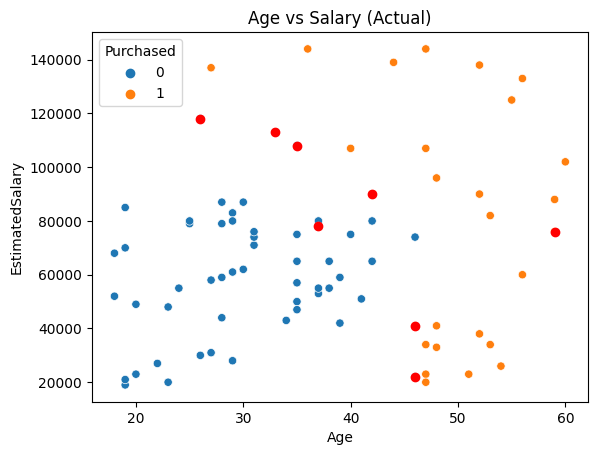

In [17]:
import seaborn as sns

sns.scatterplot(x='Age', y='EstimatedSalary', hue=y_test, data=X_test)
plt.title('Age vs Salary (Actual)')
plt.show()

sns.scatterplot(x='Age', y='EstimatedSalary', hue=y_pred, data=X_test)
plt.title('Age vs Salary (Predicted)')
plt.show()

# highlight the misclassified points
sns.scatterplot(x='Age', y='EstimatedSalary', hue=y_test, data=X_test)
plt.scatter(X_test[y_test != y_pred]['Age'],
            X_test[y_test != y_pred]['EstimatedSalary'], color='red')
plt.title('Age vs Salary (Actual)')
plt.show()

### Classification Report


In [18]:
# get the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
      target_names=['Not Purchased', 'Purchased']))


               precision    recall  f1-score   support

Not Purchased       0.92      0.92      0.92        52
    Purchased       0.86      0.86      0.86        28

     accuracy                           0.90        80
    macro avg       0.89      0.89      0.89        80
 weighted avg       0.90      0.90      0.90        80



### Important Features


In [19]:
# analyze the feature importances
importances = model.feature_importances_

# display the relative importance of each feature
pd.DataFrame(data=importances, index=X_train.columns, columns=['Importance']).sort_values(
    by='Importance', ascending=False)


,Importance
EstimatedSalary,0.502751
Age,0.486397
Gender_Male,0.006142
Gender_Female,0.004710


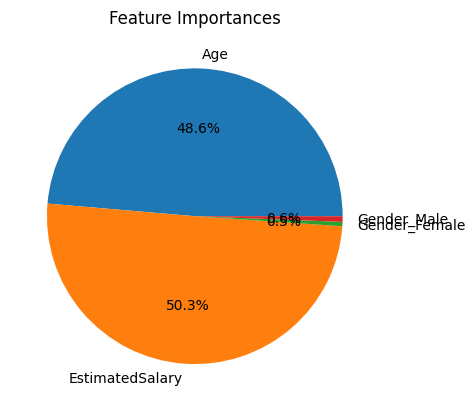

In [20]:
# visualize the feature importances in a pie chart
plt.pie(importances, labels=X_train.columns, autopct='%1.1f%%')
plt.title('Feature Importances')
plt.show()
